In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('attribution data.csv')
df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [2]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2


# Path creation

In [3]:
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()

In [4]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]

In [5]:
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

In [6]:
df_paths

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0
...,...,...,...
240103,ooooE0hkAFBkED90ChDDiBFAf,[Online Display],0
240104,ooooEBE0o0D97ACAAAnDoi3F0,[Online Display],0
240105,ooooEiB0CCoEf9fiiC90Dfhfk,[Online Display],0
240106,ooooiBh70D3k3BfAhDFfii9h7,"[Paid Search, Online Video]",0


In [7]:
df_paths['path'] = np.where( df_paths['conversion'] == 0,
['Start, '] + df_paths['channel'].apply(', '.join) + [', Null'],
['Start, '] + df_paths['channel'].apply(', '.join) + [', Conversion'])


df_paths['path'] = df_paths['path'].str.split(', ')

df_paths = df_paths[['cookie', 'path']]

In [8]:
df_paths

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,"[Start, Paid Search, Null]"
...,...,...
240103,ooooE0hkAFBkED90ChDDiBFAf,"[Start, Online Display, Null]"
240104,ooooEBE0o0D97ACAAAnDoi3F0,"[Start, Online Display, Null]"
240105,ooooEiB0CCoEf9fiiC90Dfhfk,"[Start, Online Display, Null]"
240106,ooooiBh70D3k3BfAhDFfii9h7,"[Start, Paid Search, Online Video, Null]"


# Markov Chains

In [9]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

## Transition states

In [10]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

## Transition probabilities

In [11]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [12]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [13]:
trans_matrix

,Null,Facebook,Online Video,Instagram,Online Display,Paid Search,Start,Conversion
Null,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Facebook,0.673123,0.000000,0.025577,0.173072,0.024352,0.050655,0.0,0.053220
Online Video,0.763757,0.059323,0.000000,0.031908,0.018920,0.047947,0.0,0.078146
Instagram,0.629786,0.218777,0.024118,0.000000,0.023531,0.045809,0.0,0.057979
Online Display,0.756643,0.053986,0.017299,0.029363,0.000000,0.092386,0.0,0.050324
Paid Search,0.770779,0.064442,0.029221,0.034196,0.048053,0.000000,0.0,0.053309
Start,0.000000,0.278408,0.142361,0.119188,0.142644,0.317399,0.0,0.000000
Conversion,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000


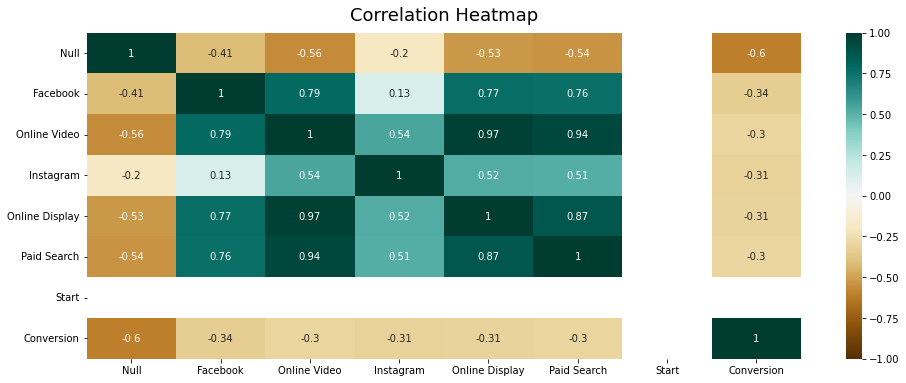

In [14]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(trans_matrix.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [15]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [16]:
removal_effects_dict

{'Facebook': 0.3547597674182721,
 'Online Video': 0.20691411655642178,
 'Instagram': 0.21731366149038456,
 'Online Display': 0.15435482356041286,
 'Paid Search': 0.3311037560086154}

In [18]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [19]:
attributions

{'Facebook': 4948.892177847523,
 'Online Video': 2886.4480895461456,
 'Instagram': 3031.521548555893,
 'Online Display': 2153.2469267590836,
 'Paid Search': 4618.891257291356}